In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns  # optional, if you like

# Read dataset
df = pd.read_csv("./cleaned_concatenated_with_gold.csv")

# Make a safe copy of the original data if needed
df_original = df.copy()

# If your CSV has an 'index' column that’s just repeated indices, drop it
# (If 'index' is not an irrelevant column, remove the drop line)
df.drop(columns=['index'], errors='ignore', inplace=True)

In [4]:
# 2.1: Winning Ratio
df['Winning_Ratio'] = df.apply(
    lambda row: row['Gold'] / row['Total_Athletes'] 
                if row['Total_Athletes'] > 0 else 0,
    axis=1
)

# 2.2: Keep a simple mapping of [NOC, Year, Total_Medal_Count] for merges/visuals
mapping_df = df[['NOC', 'Year', 'Gold']].copy()

# 2.3: Sort data by NOC, then by Year for lag-based features
df.sort_values(by=['NOC', 'Year'], inplace=True)
df.reset_index(drop=True, inplace=True)
mapping_df

,NOC,Year,Gold
0,Afghanistan,1896,0
1,Albania,1896,0
2,Algeria,1896,0
3,American Samoa,1896,0
4,Andorra,1896,0
...,...,...,...
6685,Vietnam,2024,0
6686,Virgin Islands,2024,0
6687,Yemen,2024,0
6688,Zambia,2024,0


In [5]:
# Create lag features
lags = [1, 2, 3]
for lag in lags:
    df[f'Medals_lag_{lag}'] = df.groupby('NOC')['Gold'].shift(lag)

# Rolling mean of the last 3 observations
df['Rolling_Mean_3'] = df.groupby('NOC')['Gold'].transform(lambda x: x.rolling(3).mean())

# Drop any rows that now contain NaN (due to shift/rolling)
df.dropna(inplace=True)


In [6]:
split_year = 1996
df_train = df[df['Year'] <= split_year].copy()
df_test  = df[df['Year'] > split_year].copy()

mapping_df_train = mapping_df[mapping_df['Year'] <= split_year].copy()
mapping_df_test  = mapping_df[mapping_df['Year'] > split_year].copy()

In [7]:
# Choose relevant features for modeling
features = [
    'Total_Athletes',
    'host_status',
    'Rolling_Mean_3',
    'Winning_Ratio',
    'Medals_lag_2'
]

X_train = df_train[features]
y_train = df_train['Gold']

X_test = df_test[features]
y_test = df_test['Gold']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (4460, 5)
y_train shape: (4460,)
X_test shape:  (1561, 5)
y_test shape: (1561,)


In [8]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

MAE: 0.1676970214638376
MSE: 0.6622806620812465
R²: 0.967331346460542


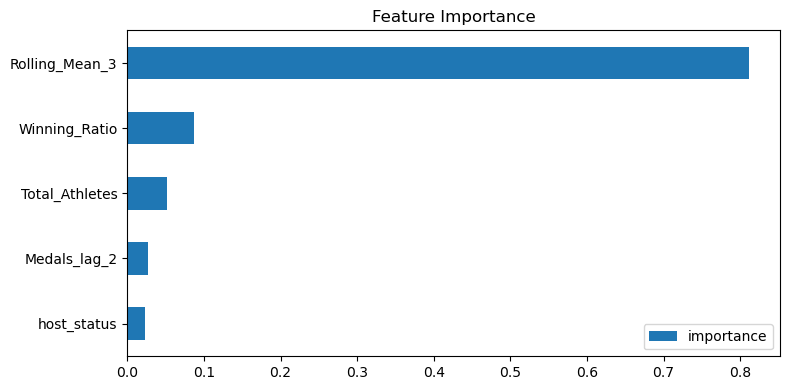

In [9]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate on test set
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

# Feature Importances
fi = pd.DataFrame(
    data=model.feature_importances_,
    index=model.feature_names_in_,
    columns=["importance"]
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(8,4))
plt.tight_layout()
plt.show()


In [16]:
# Create a Series for predictions with index aligned to y_test
predictions_series = pd.Series(y_pred, index=y_test.index, name='Predicted_Gold_Medal_Count')

# Attach to df_test
df_test['Predicted_Gold_Medal_Count'] = predictions_series

# If you want a separate DataFrame with [NOC, Year, Actual, Predicted]:
results_df = df_test[['NOC', 'Year', 'Gold']].copy()
results_df['Predicted_Gold_Medal_Count'] = df_test['Predicted_Gold_Medal_Count']

# Or you can merge with mapping_df_test to ensure the same columns:
merged_results_df = mapping_df_test.merge(
    predictions_series, 
    left_index=True, 
    right_index=True, 
    how='left'
)
merged_results_df.rename(columns={'prediction': 'Predicted_Gold_Medal_Count'}, inplace=True)


In [17]:
results_df

,NOC,Year,Gold,Predicted_Gold_Medal_Count
23,Afghanistan,2000,0,0.00
24,Afghanistan,2004,0,0.00
25,Afghanistan,2008,0,0.00
26,Afghanistan,2012,0,0.00
27,Afghanistan,2016,0,0.00
...,...,...,...,...
6685,Zimbabwe,2008,1,1.23
6686,Zimbabwe,2012,0,0.00
6687,Zimbabwe,2016,0,0.00
6688,Zimbabwe,2020,0,0.00


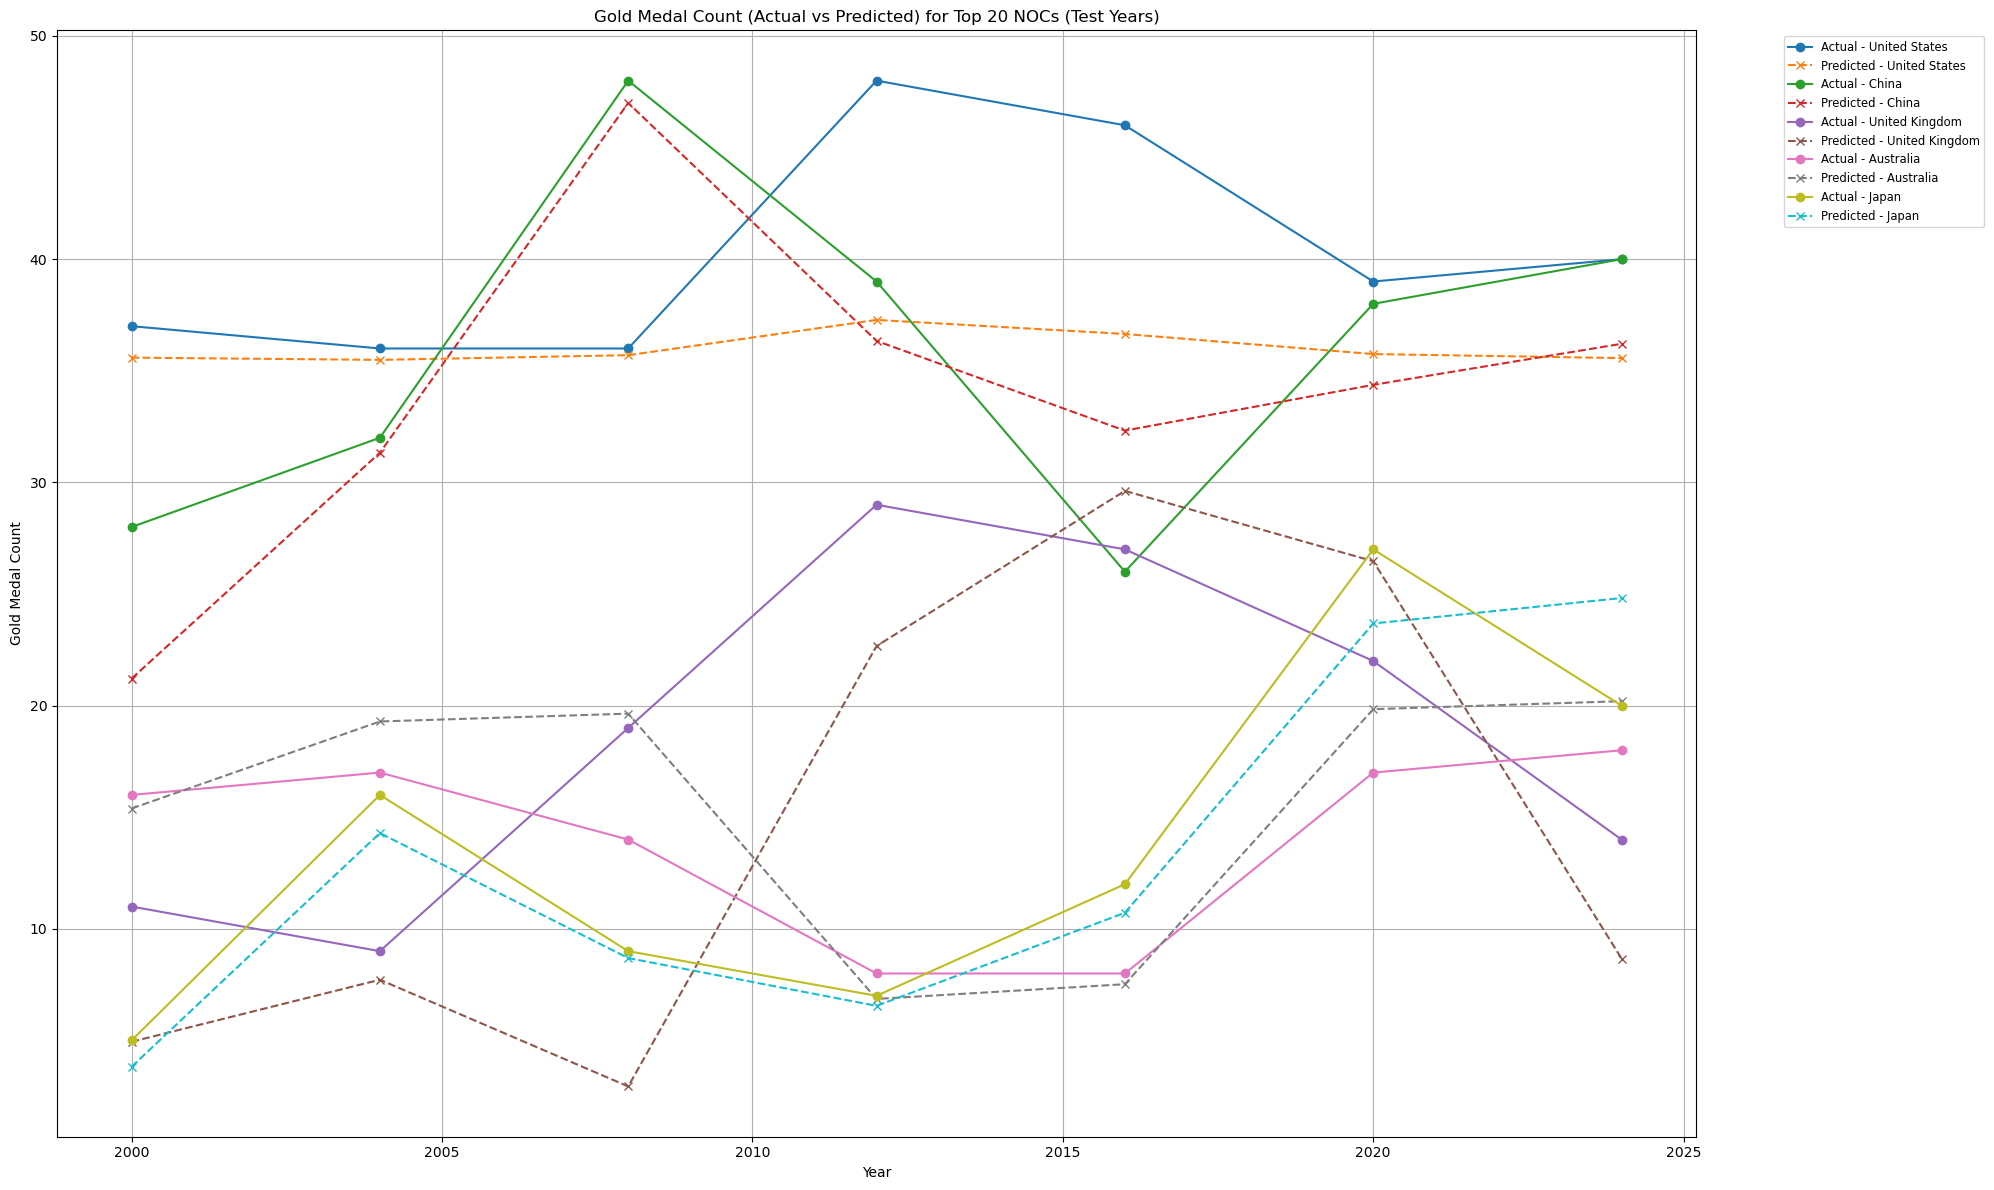

In [18]:
# Group by NOC in the test set, sum of actual medals
noc_medal_counts = df_test.groupby('NOC')['Gold'].sum().reset_index()

# Sort, pick top 20
top_20_nocs = noc_medal_counts.sort_values(by='Gold', ascending=False).head(5)['NOC'].tolist()

# Filter test data for these top 20
filtered_df = df_test[df_test['NOC'].isin(top_20_nocs)]

plt.figure(figsize=(20, 12))

for noc in top_20_nocs:
    # Data for this NOC
    noc_data = filtered_df[filtered_df['NOC'] == noc]
    
    # Plot Actual
    plt.plot(
        noc_data['Year'], 
        noc_data['Gold'], 
        marker='o',
        label=f'Actual - {noc}'
    )
    
    # Plot Predicted
    plt.plot(
        noc_data['Year'], 
        noc_data['Predicted_Gold_Medal_Count'], 
        marker='x', 
        linestyle='--',
        label=f'Predicted - {noc}'
    )

plt.xlabel('Year')
plt.ylabel('Gold Medal Count')
plt.title('Gold Medal Count (Actual vs Predicted) for Top 20 NOCs (Test Years)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
df_test['Predicted_Total_Medal_Count'] = y_pred
df_test[['Year', 'NOC', 'Gold', 'Predicted_Total_Medal_Count']].head()


,Year,NOC,Gold,Predicted_Total_Medal_Count
23,2000,Afghanistan,0,0.0
24,2004,Afghanistan,0,0.0
25,2008,Afghanistan,0,0.0
26,2012,Afghanistan,0,0.0
27,2016,Afghanistan,0,0.0


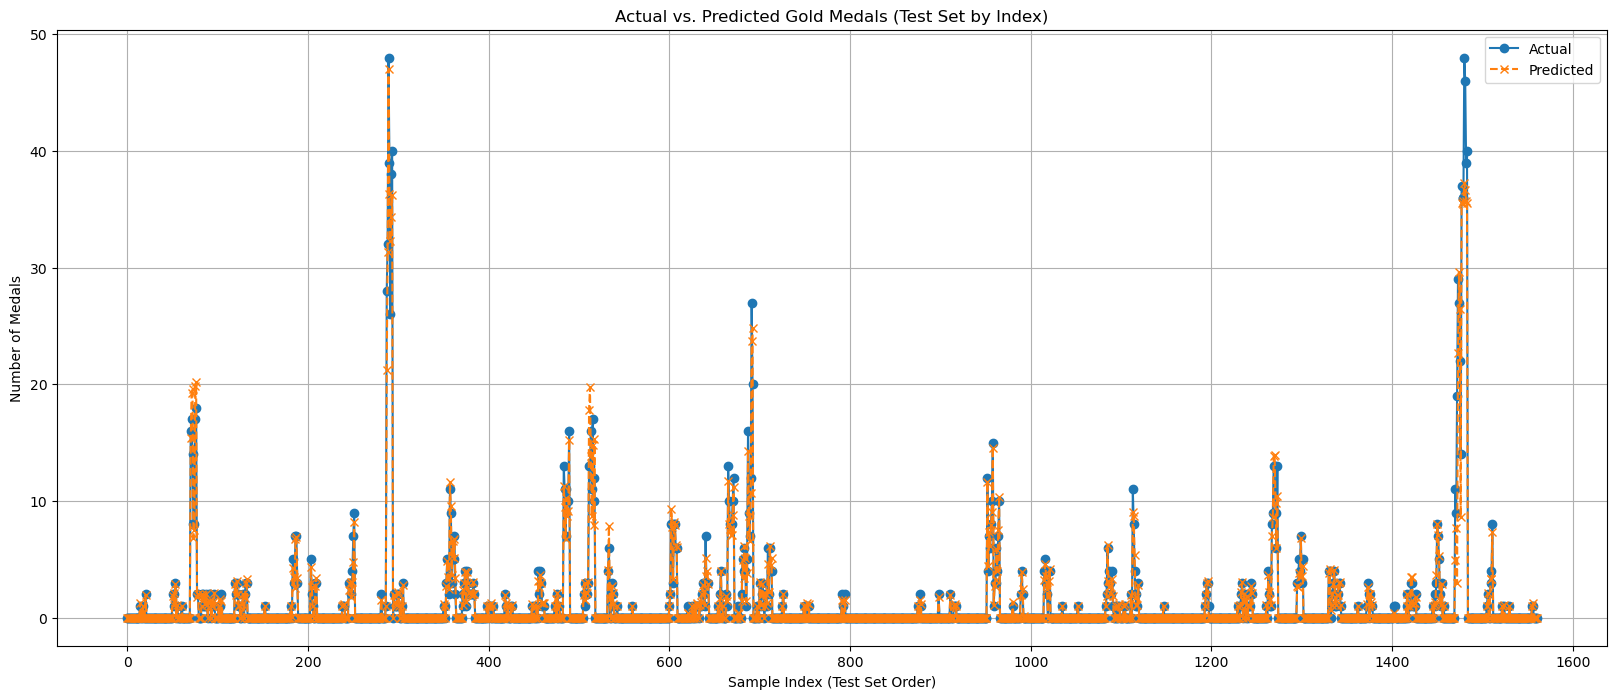

In [24]:
plt.figure(figsize=(20, 8))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Gold Medals (Test Set by Index)')
plt.xlabel('Sample Index (Test Set Order)')
plt.ylabel('Number of Medals')
plt.legend()
plt.grid(True)
plt.show()


In [21]:

# Merge with the mapping DataFrame to get NOC and Year
results_df = pd.merge(mapping_df_test, prediction_df['prediction'], left_index=True, right_index=True, how='inner')


# Visualization: Actual vs. Predicted for the United States (Test Years Only)
noc_to_visualize = 'United States'  # Or 'USA' if that's how it's in your data
noc_data = results_df[results_df['NOC'] == noc_to_visualize]

noc_data

NameError: name 'prediction_df' is not defined

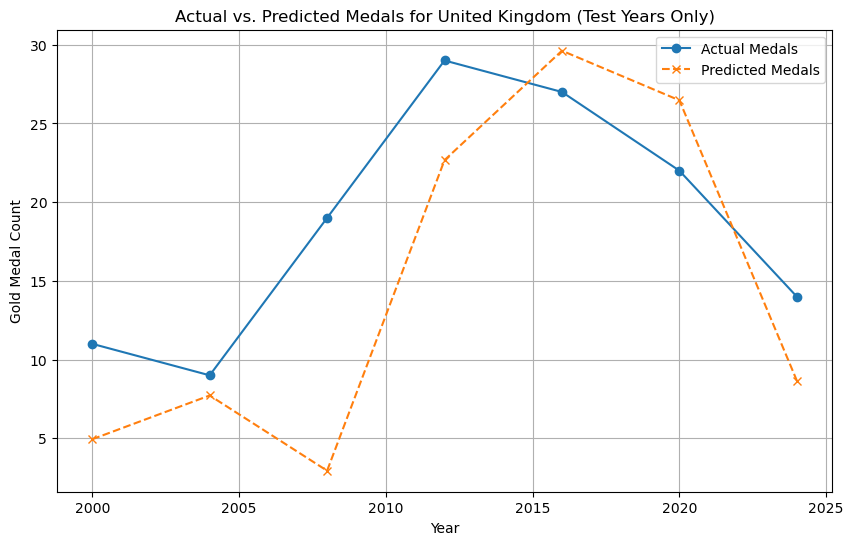

In [23]:
noc_to_visualize = 'United Kingdom'

noc_data = df_test[df_test['NOC'] == noc_to_visualize].copy()
if noc_data.empty:
    print(f"No data found for {noc_to_visualize} in the test set.")
else:
    plt.figure(figsize=(10, 6))
    plt.plot(noc_data['Year'], noc_data['Gold'], marker='o', label='Actual Medals')
    plt.plot(noc_data['Year'], noc_data['Predicted_Gold_Medal_Count'], marker='x', linestyle='--', label='Predicted Medals')
    plt.xlabel('Year')
    plt.ylabel('Gold Medal Count')
    plt.title(f'Actual vs. Predicted Medals for {noc_to_visualize} (Test Years Only)')
    plt.legend()
    plt.grid(True)
    plt.show()